# Import Libraries
     ~ Here I import all the libraries needed 

In [12]:
#import dependencies
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard,LearningRateScheduler
from keras.callbacks import EarlyStopping,CSVLogger
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
import tensorflow as tf
import random as rn
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import skimage.io
import skimage.transform
print("Libraries Loaded")

Libraries Loaded


# Hyperparameters
    ~ Here are my hyper parameters for my project. I will use thses later in my model

In [15]:
#hyperparameters for our model
batchsize=20
imgsize=150
height,width,channels=150,150,3
classes = 7 

armored_titan = '../input/titans/titans/armored'
attack_titan = '../input/titans/titans/attack'
beast_titan = '../input/titans/titans/beast'
cart_titan = '../input/titans/titans/cart'
colossal_titan = '../input/titans/titans/colossal'
female_titan = '../input/titans/titans/female'



# Custom Functions For data loading
      ~ Here I create two empty lists to use for my functions
      ~ The first function is a helper function for labeling that I will use in by build function
      ~ My Build function that I created iterates through the data assigns the labels and reads the images into cv2, decodes the RGB, and resizes them.

In [16]:
X = []
Z = []
def label_assign(img,titan):
    return titan

def build(titan,dir):
    for img in tqdm(os.listdir(dir)):
        label = label_assign(img,titan)
        path = os.path.join(dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        X.append(np.array(img))
        Z.append(str(label))

# Building My Data Using My Custom Function
    ~ Here I use my custom function to assign the labels to my data and build the dataset

In [17]:
build('Armored Titan',armored_titan)
build('Attack Titan',attack_titan)
build('Beast Titan',beast_titan)
build('Cart Titan',cart_titan)
build('Colossal Titan',colossal_titan)
build('Female Titan',female_titan)
print("Data Built And Labeled")

100%|██████████| 379/379 [00:04<00:00, 81.44it/s] 

Data Built And Labeled


# After Building The Dataset Lets Look At Some Of The Images Of The DataSet
    ~ Here I use subplots from the matplotlib library to plot some examples.
    ~ I visualize these sample images along with their labels

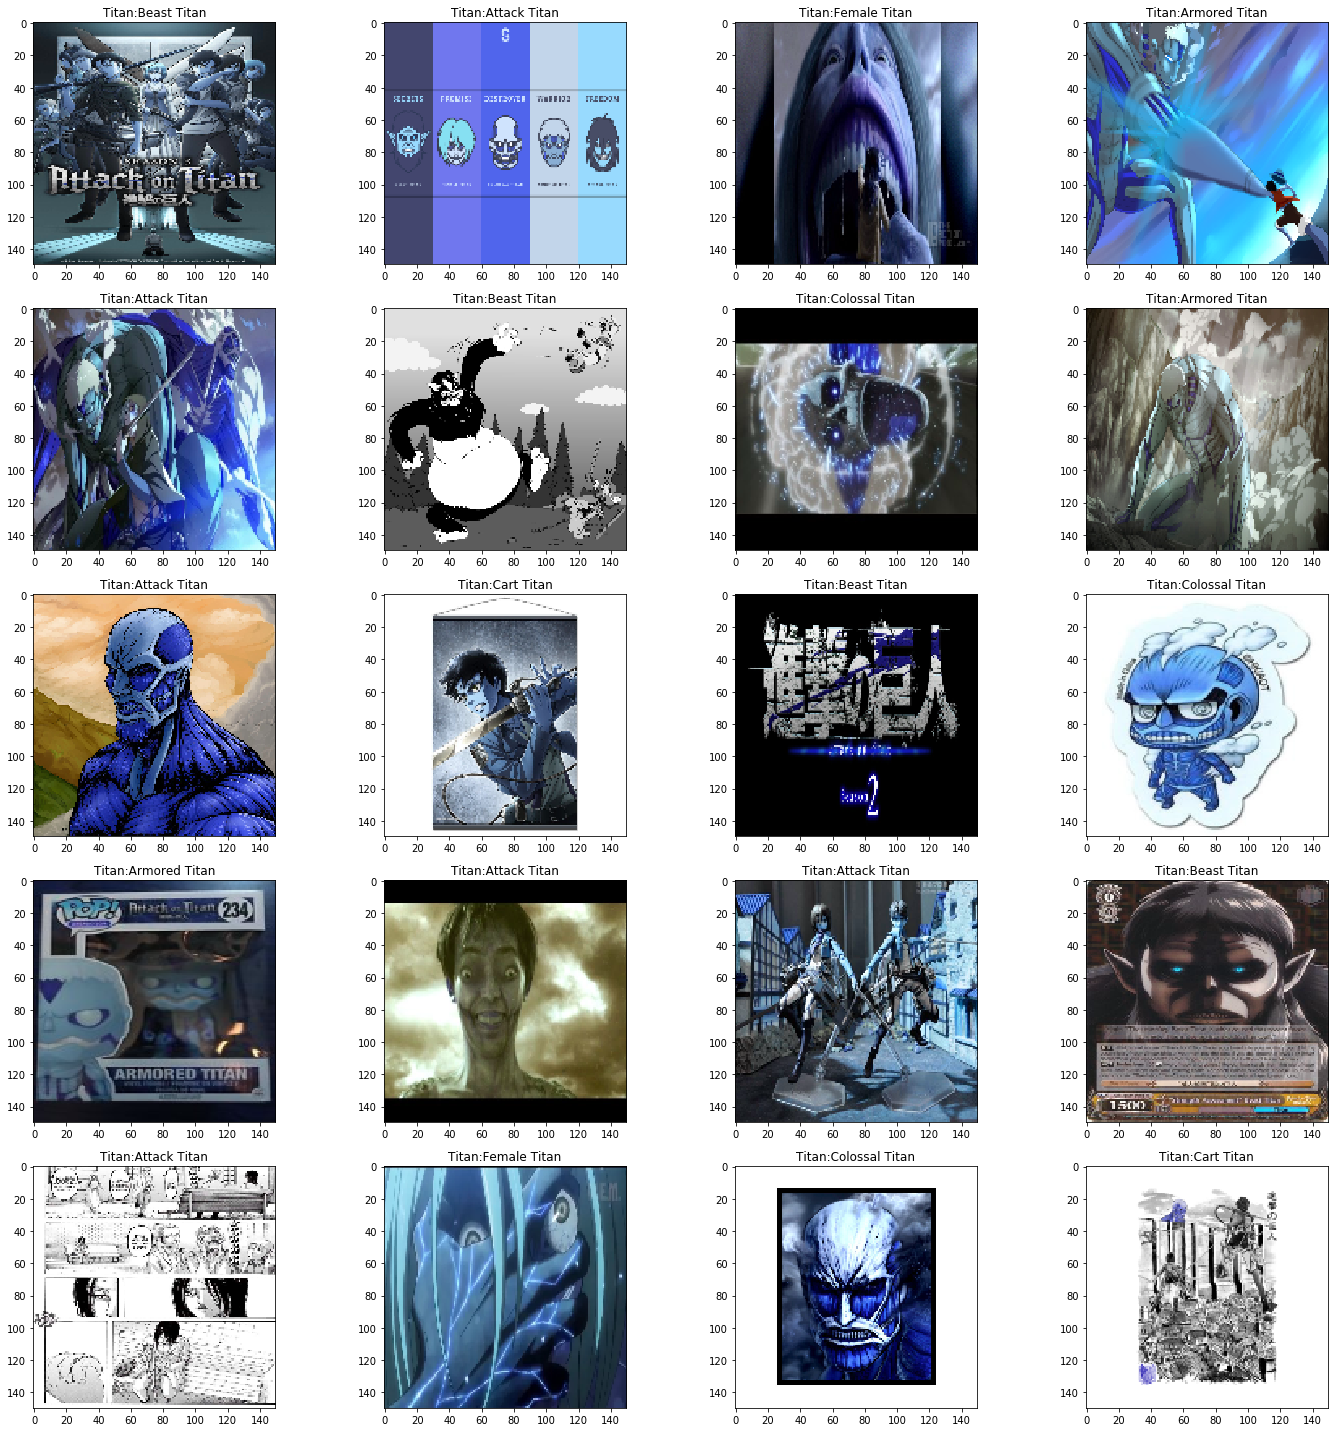

In [23]:
fig,ax = plt.subplots(5,4)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(4):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Titan:'+Z[l])
        
plt.tight_layout()

# Getting Data Ready For The Model 
    ~ First, I create my label encoder "lb"
    ~ I encode my labels by call "fit_transform"
    ~ I use to_categorical to encode my classes
    ~ I put "X" in a numpy array then normalized "X"
    ~ I use "train_test_split()" to create a validation set 

In [24]:
lb = LabelEncoder()
Y = lb.fit_transform(Z)
Y = to_categorical(Y,classes)
X = np.array(X)
X=X/255

x_trn,x_test,y_trn,y_test=train_test_split(X,Y,test_size=0.2,random_state=69)
print("Data Ready For The Model")

Data Ready For The Model


# The Model Architecture W/Transfer Learning
    ~ I use the pretained VGG16 network for feature extraction on the "imagenet" weights
    ~ Picture Of My Model Architecture will be in the repository 

In [28]:
tmodel = Sequential()
tmodel.add(Conv2D(32,kernel_size= 7,activation='relu',input_shape=(width,height,channels)))
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(64,kernel_size = 5,activation='relu'))
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(96,kernel_size = 4,activation='relu'))
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(128,kernel_size = 3,activation='relu'))
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Flatten())
tmodel.add(Dropout(0.5))
tmodel.add(Dense(classes,activation='softmax',name='classifier'))
tmodel.summary()
print("Model Architecture Complete")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 144, 144, 32)      4736      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 68, 68, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 96)        98400     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)       110720    
__________

# Data Augmentation/Data Generator
    ~ I create training and validation training generators to use data augmentation
    ~ Check the keras documentation to learning about what each transform does 

In [29]:
trn_augs = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

val_augs = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

trn_gen = trn_augs.flow(np.array(x_trn),y_trn,batch_size=batchsize)

val_gen = val_augs.flow(np.array(x_test),y_test,batch_size=batchsize)

print("Data Augmentation Completed")

Data Augmentation Completed


# Compile The Model
    ~ I compile the model
    ~ You must always compile your model before you train it
    ~ The loss function: categorical_crossentropy
    ~ Optimizer: Adam
    ~ Metrics: categorical_accuracy

In [30]:
tmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
print("Tmodel: Compiled")

Tmodel: Compiled


# Callback
    ~ I use keras callbacks to monitor my training
    ~ Callback #1: ModelCheckpoint()
    ~ Callback #2: EarlyStopping()

In [31]:
weights="{}_weights.best.hdf5".format('player')


checkpoint = ModelCheckpoint(
weights,
monitor='val_loss',
verbose=1,
save_best_only=True,
mode='min',
save_weights_only=True)

reducelr = ReduceLROnPlateau(
monitor='val_loss',
verbose=1,
save_best_only=True,
mode='min',
save_weights_only=True)

earlystop = EarlyStopping(
monitor='val_loss',
min_delta=0.01,
patience=25,
verbose=1,
mode='min')

lrsched = LearningRateScheduler(lambda x: 0.4)

csvlogger = CSVLogger(
filename='../input/tmp/training.log',
separator=',',
append=False)

tensorboard = TensorBoard(
log_dir = './logs',
histogram_freq=0,
write_graph=True,
write_images=False,
embeddings_freq=100,
embeddings_layer_names=None,
embeddings_metadata=None)


callbacks = [checkpoint,earlystop]
print("CallBacks Ready!")

CallBacks Ready!


# Train The Model!
    ~ I use history to visualize the post training results
    ~ I call "fit_generator()" load my generators
    ~ I choose 30 steps per epoch with 100 epochs
    ~ Finally, I add my list of callbacks I defined earlier and train the model!

In [32]:
history = tmodel.fit_generator(
    trn_gen,
    steps_per_epoch=30,
    epochs=100,
    validation_data=val_gen,
    validation_steps=30,
    callbacks=callbacks
)

print("Tmodel: Training Complete")

Epoch 1/100
30/30 [==============================] - 7s 241ms/step - loss: 1.8340 - categorical_accuracy: 0.1917 - val_loss: 1.7936 - val_categorical_accuracy: 0.1973

Epoch 00001: val_loss improved from inf to 1.79361, saving model to player_weights.best.hdf5
Epoch 2/100
30/30 [==============================] - 6s 203ms/step - loss: 1.8035 - categorical_accuracy: 0.1750 - val_loss: 1.7801 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss improved from 1.79361 to 1.78012, saving model to player_weights.best.hdf5
Epoch 3/100
30/30 [==============================] - 6s 205ms/step - loss: 1.7891 - categorical_accuracy: 0.2067 - val_loss: 1.7996 - val_categorical_accuracy: 0.1939

Epoch 00003: val_loss did not improve from 1.78012
Epoch 4/100
30/30 [==============================] - 6s 209ms/step - loss: 1.7937 - categorical_accuracy: 0.2131 - val_loss: 1.7900 - val_categorical_accuracy: 0.1973

Epoch 00004: val_loss did not improve from 1.78012
Epoch 5/100
30/30 [=================

# Visualize the training
    ~ I Visualize the training the training using the history object I defined earlier before fitting

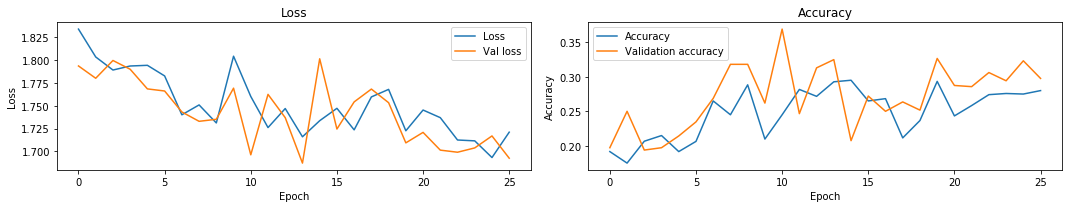

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Val loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['categorical_accuracy'], label="Accuracy")
axes[1].plot(history.history['val_categorical_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

# Model Evaluation
    ~ I call "tmodel.evaluate()" to anaylze the training and evaluate the models performance

In [34]:
tmodel_eval = tmodel.evaluate(x_test,y_test,verbose=1)
print("Tmodel: Evaluation: Test Loss", tmodel_eval[0])
print("Tmodel: Test Accuracy",tmodel_eval[1])

568/568 [==============================] - 1s 2ms/step
Tmodel: Evaluation: Test Loss 1.6808250789910975
Tmodel: Test Accuracy 0.32922535169292505


# Collecting The Model Predictions
    ~ Here I collect the models predictions by call "tmodel.predict()"

In [35]:
tmodel_predictions = tmodel.predict(x_test,verbose=1)
y_tmodel_predictions = np.argmax(tmodel_predictions,axis=1)
print("Tmodel: Predictions Collected")

568/568 [==============================] - 1s 1ms/step
Tmodel: Predictions Collected


# Save The Model
    ~ Here I save the model to a json and h5 file
    ~ json: I save this model to a json file to save a copy of the models structure
    ~ h5: I save this model in an h5 format to save a copy of the models weights
    ~ You should do this if you plan on later developing an application for your model

In [36]:
tmodel_json = tmodel.to_json()
with open("tmodel_titan.json","w") as json_file:
    json_file.write(tmodel_json)
    
tmodel.save_weights("tmodel_titan.h5")

print("Tmodel: Structure And Weights Saved")

Tmodel: Structure And Weights Saved


# The End!
    ~ Thank You For Viewing My Project!
    ~ Created By: Terrance Whitehurst